# [NML23] Assignment 3: Spectral Graph Theory and Graph Signal Processing

TAs: [Andrej Janchevski](https://people.epfl.ch/andrej.janchevski) and [Ali Hariri](https://people.epfl.ch/ali.hariri)

## Students

* Team: `20`
* Students: `Hugo Fluhr`, `Nino Herve`

## Rules

> ⚠️ **Read carefully before starting**

**Deadline:** May 1st

**Grading:**
* The integrality of Assignment 3 will be scaled to 100% and will amount to 25% of the overall assignments score.
* The total number of points is **40**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Anything outside shall not be touched, except if otherwise stated.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
> **Your answer here:**

**Submission:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

## Objective

This assignment features three exercises: 
  - label propagation
  - spectral clustering
  - spectral graph filtering

We will need a package called [PyGSP](https://pygsp.readthedocs.io/en/stable/) that provides implementations of graph signal processing operations. For this assignment, you will be implementing the GSP operations we learned in class yourself, while we will give the PyGSP commands so you can double check the results. PyGSP can be installed in a conda environment by running:

`!pip install pygsp`

NB: You are encouraged to try different random seeds, remember to re-run the whole notebook after doing so.

In [1]:
!pip install scipy==1.8.1
!pip install pygsp
import pygsp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Try different random seeds!
seed = 57
random.seed(seed)
np.random.seed(seed)

## Exercise 1: Spectral clustering [18pt]

In this exercise, we will perform both positional-feature-based as well as spectral clustering on two different graph structures (disjoint box graphs and crescent moon) and analyze the influence of the features and graph on the obtained clusters.

*For additional information on spectral clustering, we refer to this [tutorial paper](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf). For practical aspects of the algorithm, the relevant sections are 1, 2, 3, 4, 8.*

### Load and visualize data

In [3]:
def get_boxes(num_boxes:int = 5, num_random_edges:int = 5):
  boxes = [nx.grid_2d_graph(m=n,n=n) for n in range(3, 3 + num_boxes)]
  pos = np.concatenate([np.array(list(nx.kamada_kawai_layout(box).values())) 
                        + i * 1.25 for i, box in enumerate(boxes)])
  G = nx.disjoint_union_all(boxes)
  return G, pos

In [4]:
def get_moons(num_moons:int = 5, num_points:int=1000, eps:float=2.5e-2):
  points = np.random.uniform(-1, 1, size=(num_points, 2))
  x, y = points[:, 0], points[:, 1]
  circ = x**2 + y**2 <= 1
  circ2 = (x - 0.5) ** 2 + y ** 2 <= 1
  moon = points[circ & ~circ2]
  moons = np.concatenate([np.array([1 - 2* (i%2), 1]) 
                          * (moon + np.array([0, i * 1.5]))
                          for i in range(num_moons)])
  moon_dists = np.sum((moons[np.newaxis] 
                       - moons[:, np.newaxis]) ** 2, axis=2)
  moon_edges = np.vstack(((0 < moon_dists) & (moon_dists < eps)).nonzero()).T
  moon_graph = nx.empty_graph(n=len(moons))
  moon_graph.add_edges_from(moon_edges)
  return moon_graph, moons

In [5]:
def plot_graph(G, pos, node_clusters=None):
  plt.figure(figsize=(5, 5))
  nx.draw(G, pos=pos, node_size=10, 
          node_color=[plt.cm.Set1(c) for c in node_clusters] 
                      if node_clusters is not None else "gray")
  plt.show()

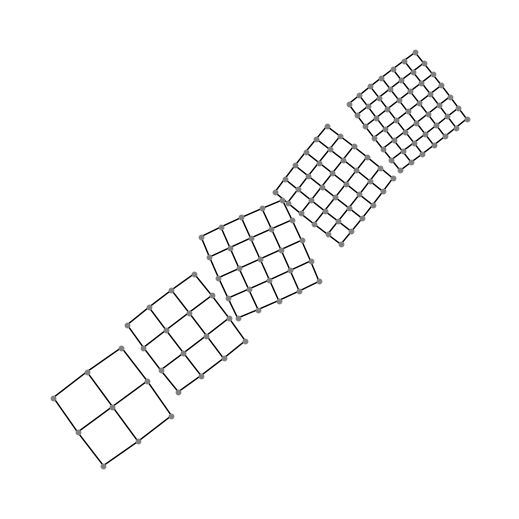

In [6]:
num_clusters = 5
G_boxes, G_boxes_pos = get_boxes(num_clusters)
plot_graph(G_boxes, G_boxes_pos)

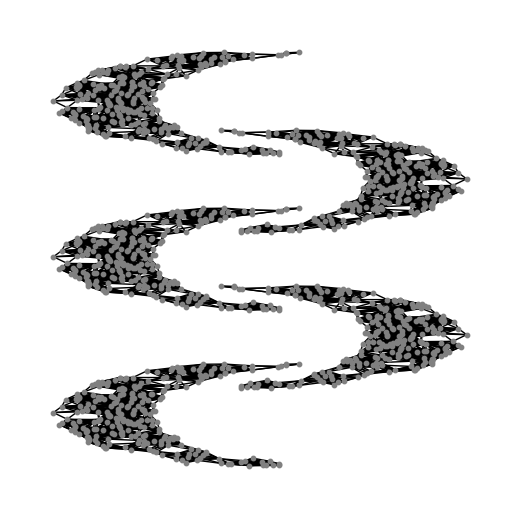

In [7]:
G_moons, G_moons_pos = get_moons(num_clusters)
plot_graph(G_moons, G_moons_pos)

### Part 1: K-means

**Question 1 (code) [2pt]: Run K-means with 5 clusters on both graphs.**

You can use the scikit learn function (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [8]:
# Your solution here ###########################################################
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=seed, n_init='auto')
G_boxes_clusters = kmeans.fit_predict(G_boxes_pos)
G_moons_clusters = kmeans.fit_predict(G_moons_pos)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

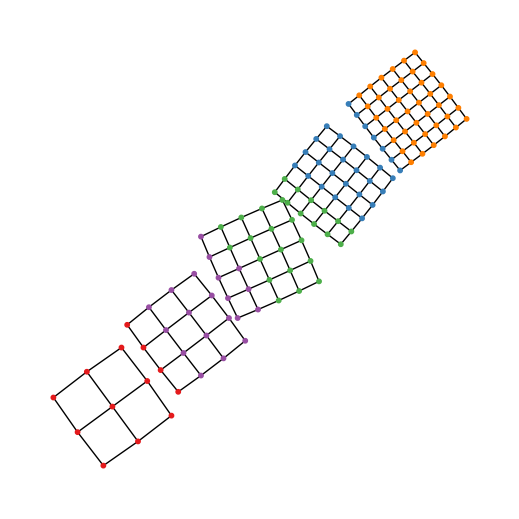

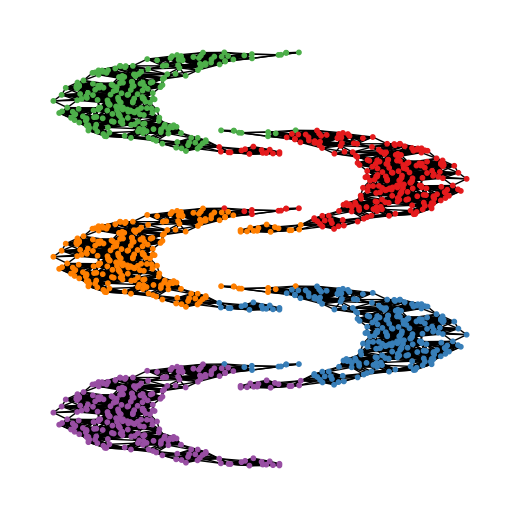

In [9]:
plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters)
plot_graph(G_moons, G_moons_pos, G_moons_clusters)

**Question 2 (analysis) [1pt]: Why is the standard implementation of K-means not suited to the data we have?**

**Your answer here:**  
K-means operates on Euclidean distances (nodes close in space belong to the same cluster) and assumes that the clusters are roughly spherical. The data in this assignment break these assumptions. We are given additional information, which is the connectivity of the data.

### Part 2: Spectral clustering

**Question 3 (code): Fill `compute_laplacian` [6pt], `compute_number_connected_components` [2pt], `spectral decomposition` [2pt]. These functions should work for all 3 definitions of the laplacian (combinatorial, symmetric normalized, random walk).**

Warning: the eigendecomposition of a non symmetric matrix returns complex numbers, even if the imaginary part is in fact 0.

In [10]:
def compute_laplacian(adjacency: np.ndarray, normalize: str):
    """ normalize: can be None, 'sym' or 'rw' for the combinatorial, symmetric normalized or random walk Laplacians
    Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # Your solution here ###########################################################
    if not isinstance(adjacency, np.ndarray):
        adjacency = adjacency.toarray()
    D = np.diag(adjacency.sum(axis=1))

    if normalize==None:
        return D - adjacency
    elif normalize=='sym':
        Dinv = np.linalg.inv(D)
        I = np.identity(D.shape[0])
        return I - (np.sqrt(Dinv) @ adjacency @ np.sqrt(Dinv))
    elif normalize=='rw':
        Dinv = np.linalg.inv(D)
        I = np.identity(D.shape[0])
        return I - (Dinv @ adjacency)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
    raise ValueError(f'Unknown normalization: {normalize}')


def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    # Your solution here ###########################################################
    return np.sum(lamb<threshold)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    # Your solution here ###########################################################
    lamb, U = np.linalg.eig(laplacian)
    sort_id = np.argsort(lamb)
    lamb = lamb[sort_id]
    U = U[:,sort_id]

    return lamb, np.real(U)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [11]:
def get_laplacians(G: nx.Graph):
  A = nx.adjacency_matrix(G).toarray().astype(float)

  laplacian_comb = compute_laplacian(A, normalize=None)

  laplacian_norm = compute_laplacian(A, normalize='sym')

  laplacian_rw = compute_laplacian(A, normalize='rw')

  return laplacian_comb, laplacian_norm, laplacian_rw

laplacian_comb_boxes, laplacian_norm_boxes, laplacian_rw_boxes = get_laplacians(G_boxes)
laplacian_comb_moons, laplacian_norm_moons, laplacian_rw_moons = get_laplacians(G_moons)

This is how we can load a graph with PyGSP and compute the Laplacian (the library doesn't implement the random-walks Laplacian). 

Try the following commands to test whether your implementation is accurate!

In [12]:
def get_laplacians_pygsp(G: nx.Graph):
  A = nx.adjacency_matrix(G).toarray().astype(float)
  G_pygsp = pygsp.graphs.Graph(A)

  G_pygsp.compute_laplacian("combinatorial")
  laplacian_comb_true = G_pygsp.L.toarray().astype(float)

  G_pygsp.compute_laplacian("normalized")
  laplacian_norm_true = G_pygsp.L.toarray().astype(float)

  return G_pygsp, laplacian_comb_true, laplacian_norm_true

G_boxes_pygsp, laplacian_comb_boxes_true, laplacian_norm_boxes_true = get_laplacians_pygsp(G_boxes)
print(f"Combinatorial Laplacian correct: {np.allclose(laplacian_comb_boxes, laplacian_comb_boxes_true)}")
print(f"Normalized Laplacian correct: {np.allclose(laplacian_norm_boxes, laplacian_norm_boxes_true)}")

Combinatorial Laplacian correct: True
Normalized Laplacian correct: True


In [13]:
lamb_comb_boxes, U_comb_boxes = spectral_decomposition(laplacian_comb_boxes)
lamb_comb_moons, U_comb_moons = spectral_decomposition(laplacian_comb_moons)

lamb_norm_boxes, U_norm_boxes = spectral_decomposition(laplacian_norm_boxes)
lamb_norm_moons, U_norm_moons = spectral_decomposition(laplacian_norm_moons)

lamb_rw_boxes, U_rw_boxes = spectral_decomposition(laplacian_rw_boxes)
lamb_rw_boxes = np.real(lamb_rw_boxes)
lamb_rw_moons, U_rw_moons = spectral_decomposition(laplacian_rw_moons)
lamb_rw_moons = np.real(lamb_rw_moons)

**Question 4 (code) [4pt]: Implement spectral clustering for the 3 possible definitions of the Laplacian.**

In [14]:
from sklearn.preprocessing import normalize

class SpectralClustering():
    def __init__(self, n_classes: int, normalize: str):
        self.n_classes = n_classes
        self.normalize = normalize
        # Your solution here ###########################################################
        self.clustering_method = KMeans(n_classes, random_state=seed, n_init='auto')
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
    def fit_predict(self, G: nx.Graph):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        # Your solution here ###########################################################
        A = nx.adjacency_matrix(G).toarray().astype(float)
        L = compute_laplacian(A, normalize=self.normalize)
        _,U = spectral_decomposition(L)
        U_reduced = U[:,:self.n_classes]
        if self.normalize == 'sym':
            U_reduced = normalize(U_reduced, axis=1, norm='l2')
            
        return self.clustering_method.fit_predict(U_reduced)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [15]:
spectral_clustering = SpectralClustering(n_classes=num_clusters, normalize=None)
G_boxes_clusters_comb = spectral_clustering.fit_predict(G_boxes)
G_moons_clusters_comb = spectral_clustering.fit_predict(G_moons)

spectral_clustering_sym = SpectralClustering(n_classes=num_clusters, normalize='sym')
G_boxes_clusters_norm = spectral_clustering_sym.fit_predict(G_boxes)
G_moons_clusters_norm = spectral_clustering_sym.fit_predict(G_moons)

spectral_clustering_rw = SpectralClustering(n_classes=num_clusters, normalize='rw')
G_boxes_clusters_rw = spectral_clustering_rw.fit_predict(G_boxes)
G_moons_clusters_rw = spectral_clustering_rw.fit_predict(G_moons)

Spectral clustering with combinatorial Laplacian

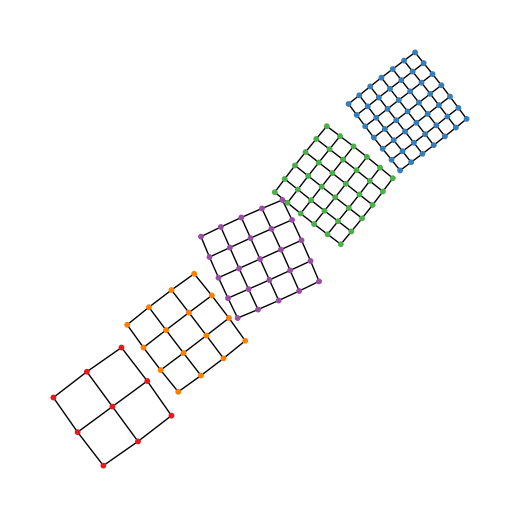

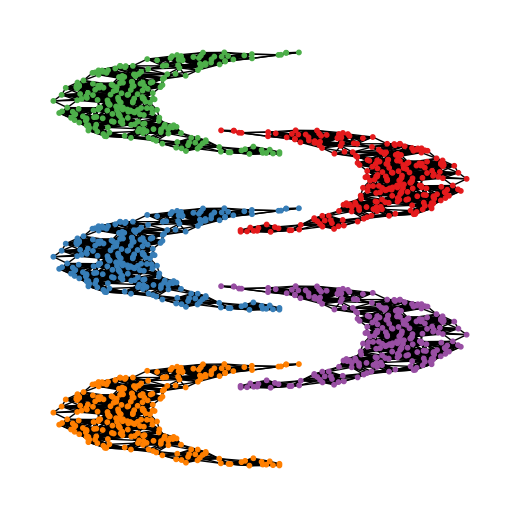

In [16]:
plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_comb)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_comb)

Spectral clustering with symmetric normalized Laplacian

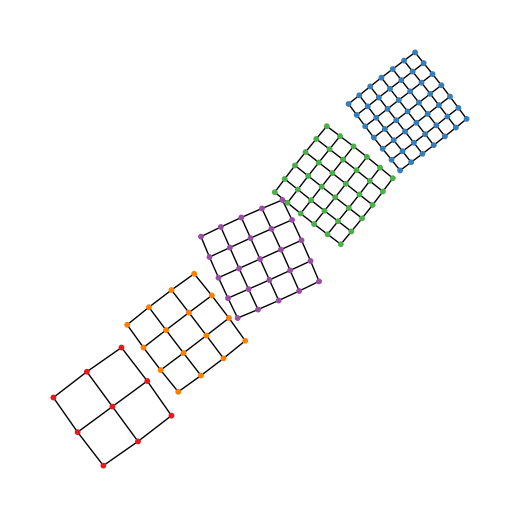

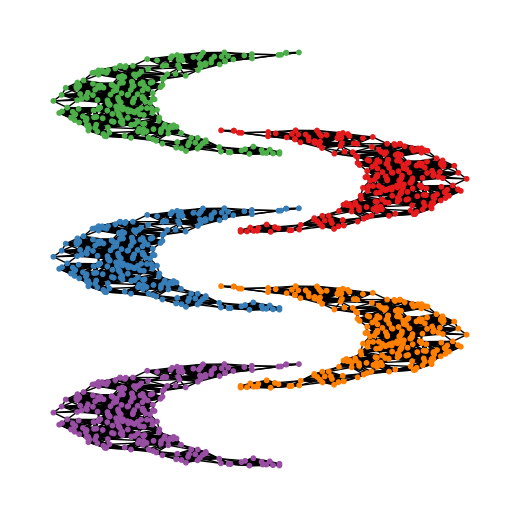

In [17]:
plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_norm)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_norm)

Spectral clustering with random walks Laplacian

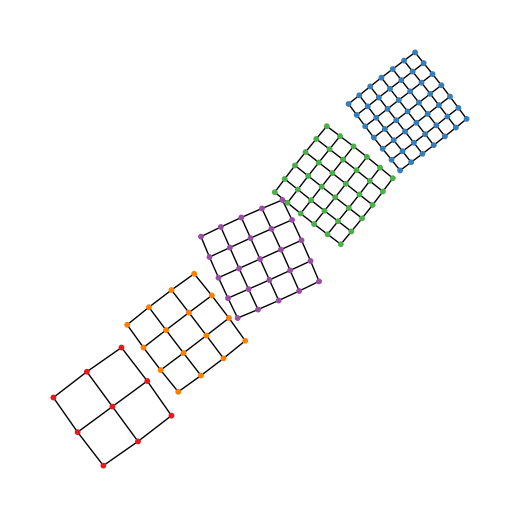

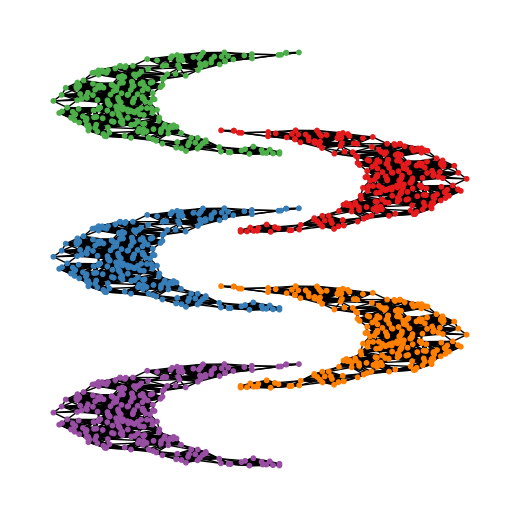

In [18]:
plot_graph(G_boxes, G_boxes_pos, G_boxes_clusters_rw)
plot_graph(G_moons, G_moons_pos, G_moons_clusters_rw)

**Question 5 (analysis) [1pt]: Do the clusters make more sense with the spectral methods compared to K-means?**

**Your answer here:**

Yes, each component is nicely segreated as can be excpected since the graphs are composed of disconnected components.

## Exercise 2: Spectral filtering [10pt]

This exercise covers basic notion of filtering in the graph Fourier domain. We will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.
We construct the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [19]:
from pygsp.graphs import Bunny
from mpl_toolkits.mplot3d import Axes3D # as Axes3d

<ipython-input-20-df0546834c75>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
<ipython-input-20-df0546834c75>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7


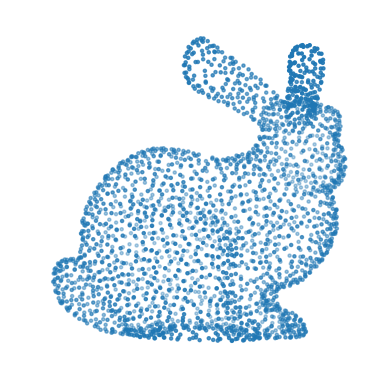

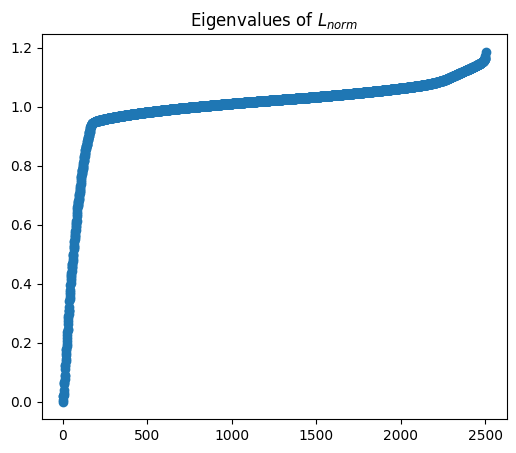

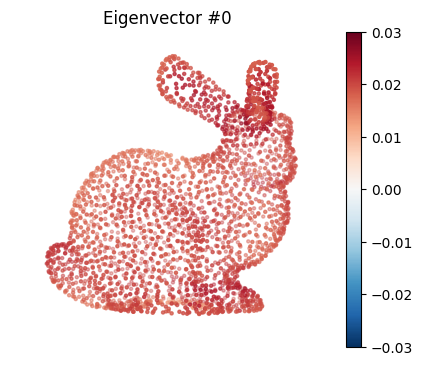

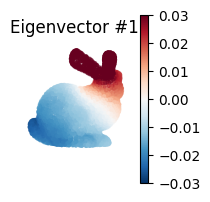

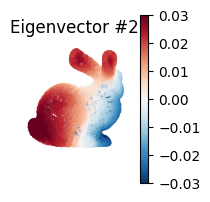

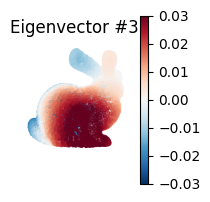

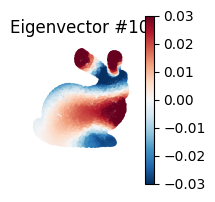

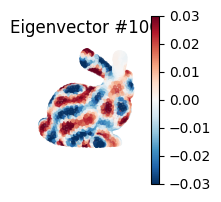

In [20]:
# Define the graph
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]


def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    """ PLot a signal x on the bunny graph. """
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)
    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)
    plt.show()
        
        
plt.subplot(111, projection='3d')
plot_bunny()

# Compute the normalized Laplacian
laplacian = compute_laplacian(adjacency, normalize='sym')
laplacian = (laplacian + laplacian.T) / 2    # Make sure the matrix is symmetric despite numerical errors
lam, U = spectral_decomposition(laplacian)

# This lines should normally not be needed, but it seems that not all eigenvalues are always sorted
argsort = np.argsort(lam)
lam = lam[argsort]
U = U[:, argsort]

# Eigenvalues plot
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(len(lam)), lam)
plt.title('Eigenvalues of $L_{norm}$')
plt.show()


# Plot some eigenvectors of the graph
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

**Question 6 (analysis) [2pt]: How does the intuitive notion of "smoothness" relates to the eigenvalue corresponding to an eigenvector? How can the smoothness of a signal be measured?**

**Your answer here:**  
The smoothness of the signal is related to how it varies between connected nodes. The eigenvectors corresponding to large eigenvalues vary much more along the graph which means that they have lower smoothness. Hence higher eigenvalues correspond to lower smoothness.  

The global smoothness of a signal on a graph can be measured with the quadratic form of the Graph Laplacian : 
$$ 
f^T L f
$$

**Question 7 (code) [3pt]: Implement the Graph Fourier Transform (GFT) of a graph signal and its inverse.**

In [21]:
def GFT(signal: np.array, U: np.ndarray):
    """ signal: float array of size n.
        U: matrix of size n x n containing one eigenvector per column.
    """
    # Your solution here ###########################################################
    return np.tensordot(U, signal, ([0], [0]))
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

def iGFT(fourier_coefficients: np.ndarray, U: np.ndarray):
    """ fourier_coefficients: float array of size n, containing a signal represented in the spectral domain
        U: matrix of size n x n containing one eigenvector per column.
    """
    # Your solution here ###########################################################
    return np.tensordot(U, fourier_coefficients, ([1], [0]))
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Filtering
We first define a signal `x`, and a noisy version of it `x_noisy`.

<ipython-input-20-df0546834c75>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, projection='3d')
<ipython-input-20-df0546834c75>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7


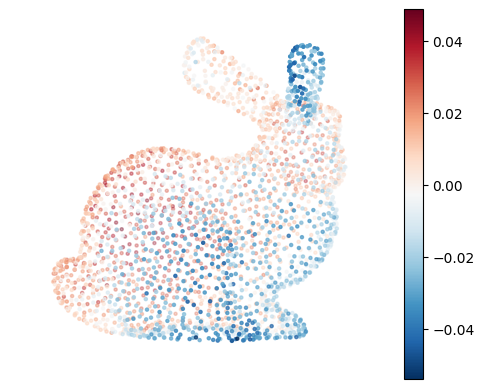

In [22]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3 * noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

We will try to extract the signal from the noise using graph filters. Let us start by creating 4 ideal graph filters: a low pass, a band pass, a high pass, and the filter that implements the solution of Tikhonov regularization.

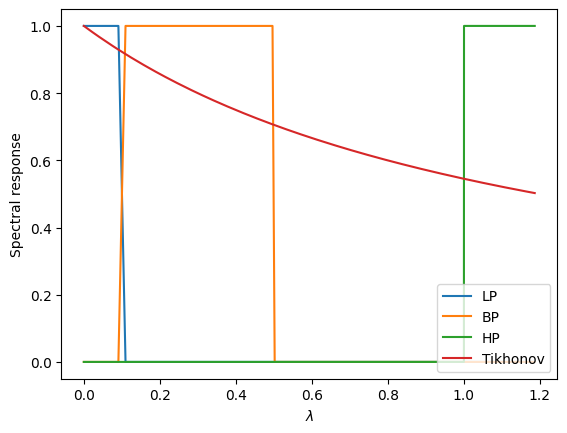

In [23]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

alpha = 0.99 / np.max(lam)

ideal_tk = np.ones((n_nodes,))
ideal_tk = 1 / (1 + alpha*lam)

# Let's plot the spectral responses:

plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.show()

**Question 8 (code) [4pt]: Implement the filtering function**

In [24]:
def filter_signal(x: np.array, spectral_response: np.array, U: np.ndarray):
    """ Return a filtered signal
        The filter is defined in the spectral domain by its value on each eigenvector
        x (float array of size n): input signal
        spectral response (float array of size n): value of the filter at each eigenvalue
        U (n x n matrix): eigenvectors (one per column).
        returns:
        out (float array of size n): Filtered signal
    """
    # Your solution here ###########################################################

    if x.ndim > 1:
        spectral_response = np.expand_dims(spectral_response, -1)
    return iGFT(GFT(x, U) * spectral_response, U)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<ipython-input-20-df0546834c75>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7


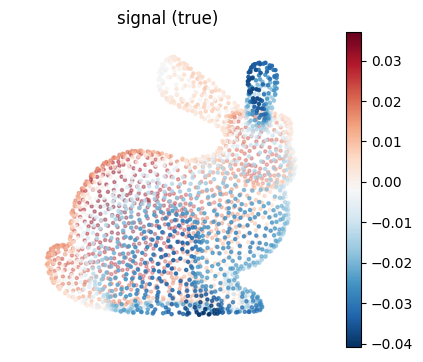

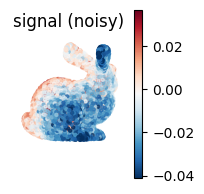

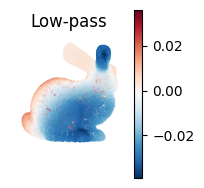

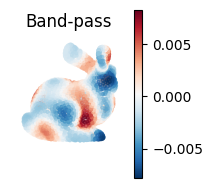

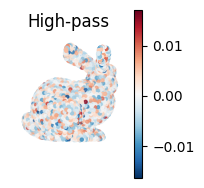

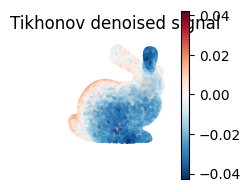

In [25]:
x_lp = filter_signal(x_noisy,ideal_lp, U)
x_bp = filter_signal(x_noisy,ideal_bp, U)
x_hp = filter_signal(x_noisy,ideal_hp, U)
x_tk = filter_signal(x_noisy,ideal_tk, U)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

This is how we can filter a graph signal with PyGSP directly. 

Try the following commands to test whether your implementation is accurate!

LP filtering correct: True
BP filtering correct: True
HP filtering correct: True
Tikhonov filtering correct: True


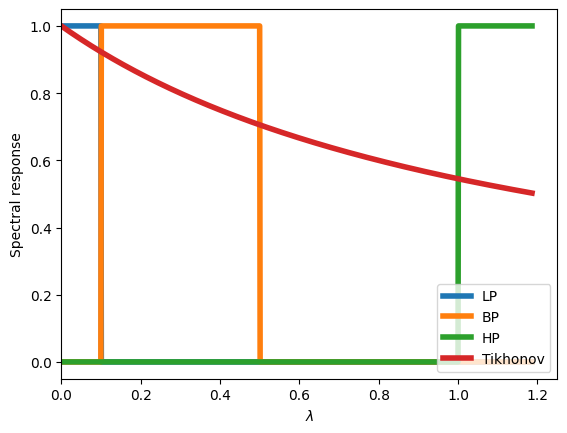

In [26]:
def get_filters_pygsp(G_pygsp: pygsp.graphs.Graph):
  G.compute_laplacian("normalized")
  G.L = (G.L + G.L.T) / 2 
  G.compute_fourier_basis()

  ideal_lp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: (x < 0.1).astype(float))
  ideal_bp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: ((0.1 <= x) 
                                        & (x <= 0.5)).astype(float))
  ideal_hp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: (x > 1.0).astype(float))
  ideal_tk_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: 1 / (1 + alpha * x))

  return ideal_lp_pygsp, ideal_bp_pygsp, ideal_hp_pygsp, ideal_tk_pygsp

fig, ax = plt.subplots()
for filter_name, x, ideal_true in zip(["LP", "BP", "HP", "Tikhonov"], 
                                      [x_lp, x_bp, x_hp, x_tk], 
                                      get_filters_pygsp(G)):
  ideal_true.plot(plot_eigenvalues=False, ax=ax)
  x_true = ideal_true.filter(x_noisy)
  print(f"{filter_name} filtering correct: {np.allclose(x, x_true, atol=1e-2)}")
plt.xlim(0, 1.25)
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(labels=["LP", "BP", "HP", "Tikhonov"], loc='lower right')
plt.show()

**Question 9 (analysis) [1pt]: What kind of filter does Tikhonov regularization implement?**

**Your answer here:**  
A Tikhonov regularization implements a low pass filter. However there is no precise cut-off frequency; the gain of higher graph frequencies is continuously reduced.

## Exercise 3: Label propagation [12pt]

We will implement label propagation, which is an algorithm for semi-supervised learning: given a few labeled points, the goal is to assign labels to other points. We refer to [this paper](http://mlg.eng.cam.ac.uk/zoubin/papers/CMU-CALD-02-107.pdf) for the details about the algorithm.

In [27]:
import pygsp.graphs
import numpy as np
import numpy.linalg as LA
import numpy.random as npr
import matplotlib.pyplot as plt

We will use points sampled from the Swiss roll graph. Note that the (weighted) adjacency matrix **A** is already provided. If it was not the case, we would need to build a similarity graph (using nearest neighbors or an epsilon-neighborhood).

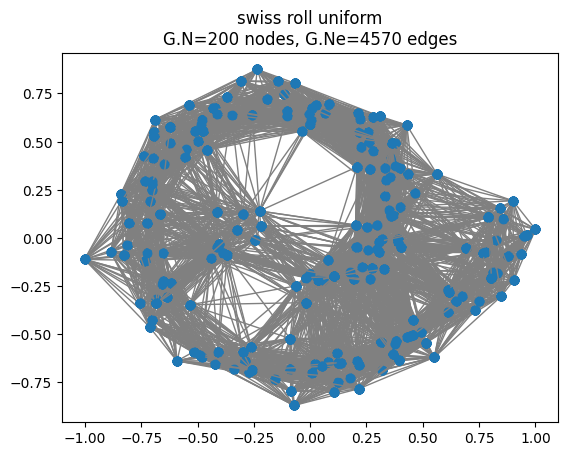

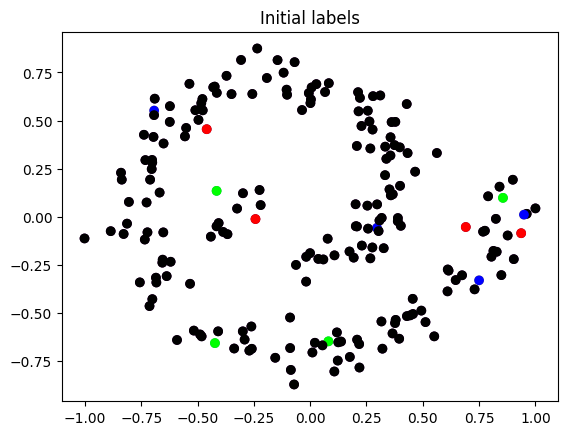

In [28]:
n = 200


def sample_signal(n, num_classes=3, num_labels_per_class=4, seed=0):
    npr.seed(seed)
    indices = npr.choice(n,
                         size= num_labels_per_class * num_classes,
                         replace=False)
    indices = indices.reshape(num_labels_per_class, num_classes)

    x = np.zeros((n, num_classes))
    for j in range(num_classes):
        x[indices[:, j], j] = 1
    return x


swiss_roll = pygsp.graphs.SwissRoll(n, dim=2, noise=0.05)
A = swiss_roll.W                    # weighted adjacency matrix
coords = swiss_roll.coords          # coordinates
x = sample_signal(n)

swiss_roll.plot()

plt.figure()
c=np.argmax(x, axis=1)
plt.scatter(coords[:, 0], coords[:, 1], c=np.argmax(x, axis=1))
plt.scatter(coords[:, 0], coords[:, 1], c=x)
plt.title("Initial labels")
plt.show()

**Question 10 (code) [6pt]: Go through the paper and implement the label propagation algorithm of section 2.2**

In [29]:
class LabelPropagation():
    def __init__(self, num_iters, stopping_criterion=None):
        self.num_iters = num_iters
        self.stopping_criterion = stopping_criterion
    
    def __call__(self, A, x, coords, plot_each_iteration=True):
        """ A: n x n: weighted adjacency matrix
            x: n x d matrix containing the initial labels
            coords: n x 2 matrix containing the point coordinates.
            plot_each_iteration: bool.
            Return:
            pred: n x d prediction matrix (each row should sum to 1)
        """
        plt.figure()
        plt.scatter(coords[:, 0], coords[:, 1], c=x)
        plt.title(f"Initial state")
        plt.show()
        
        # Your solution here ###########################################################

        x = x.copy()
        A = A.copy().toarray()
        labeled_indices = np.argwhere(np.sum(x,axis=1)==1)
        initial_labels = x[labeled_indices,:]
        T = A/A.sum(axis=1, keepdims=True)

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        for i in range(self.num_iters):
            # Your solution here ###########################################################

            x = np.matmul(T,x)
            #row_norm = x.sum(axis=1).flatten()
            #row_norm[row_norm==0]=1
            #x = x/row_norm[:,None]
            x = normalize(x, axis=1, norm='l1')
            x[labeled_indices,:] = initial_labels

            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

            if plot_each_iteration:
                plt.figure()
                plt.scatter(coords[:, 0], coords[:, 1], c=x)
                plt.title(f"After Iteration {i}")
                plt.show()
                
            if self.stopping_criterion is not None:
                if self.stopping_criterion.step(x):
                    print(f"Stopping criterion triggered after {i} iterations.")
                    break
        return x
    
    
def plot_predictions(x, coords):
    """ x: n x d matrix containing the predictions """
    predictions = np.argmax(x, axis=1)
    y = np.zeros(x.shape)
    for i in range(x.shape[0]):
        y[i, predictions[i]] = 1
    plt.figure()
    plt.scatter(coords[:, 0], coords[:, 1], c=y)
    plt.title("Final predictions")
    plt.show()

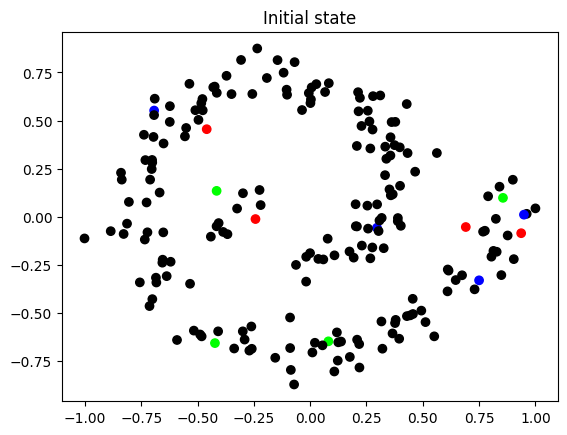

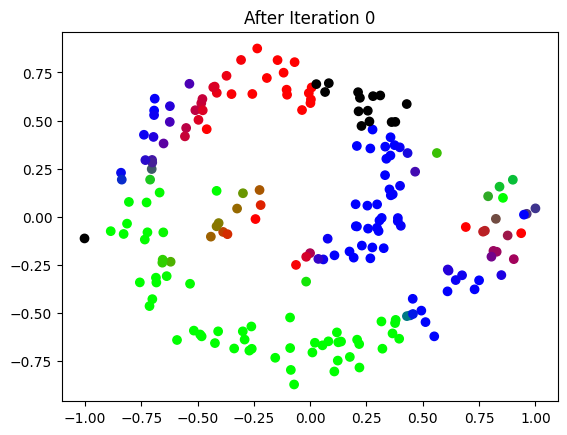

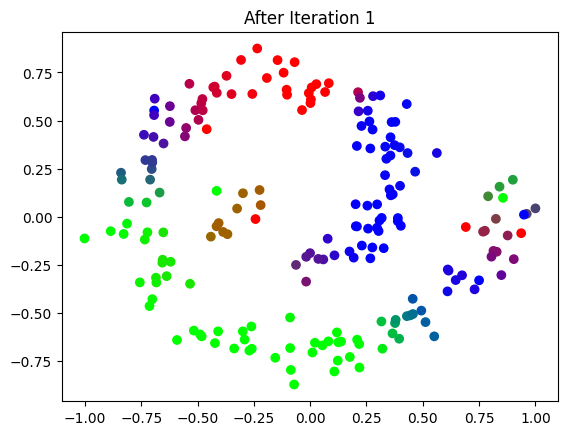

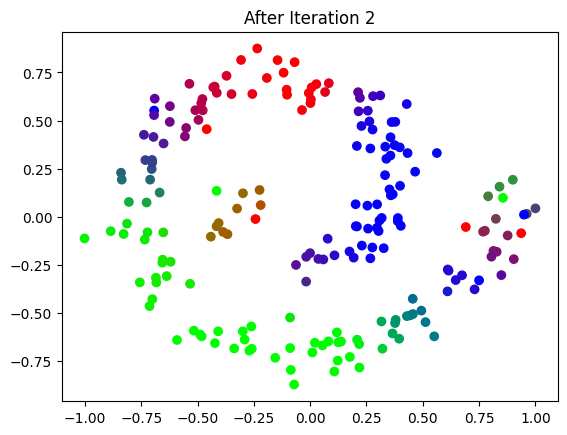

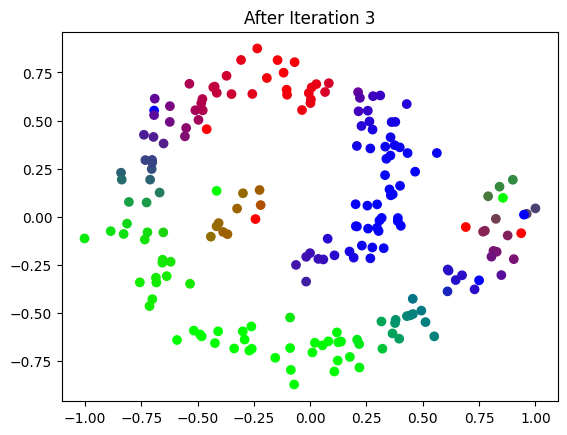

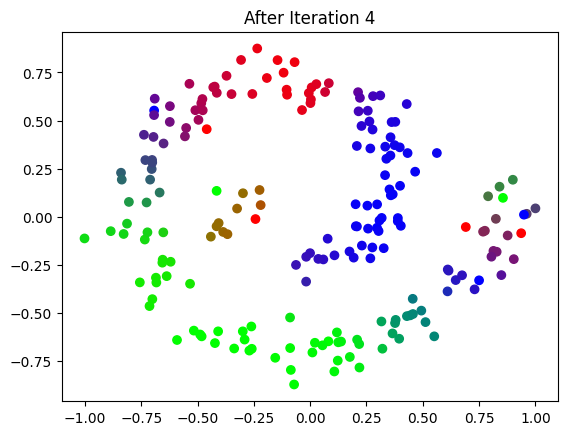

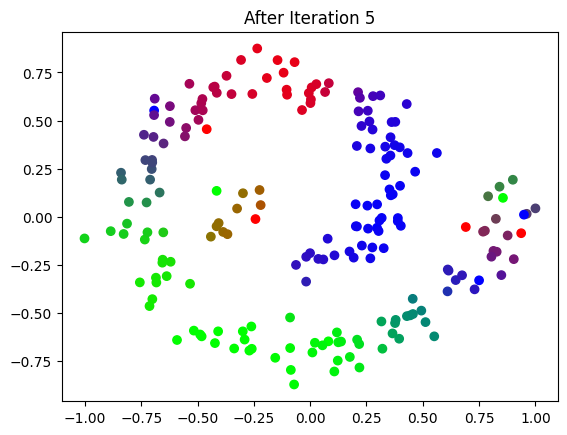

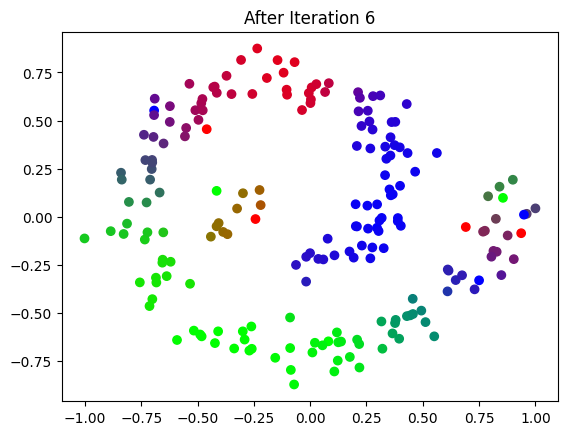

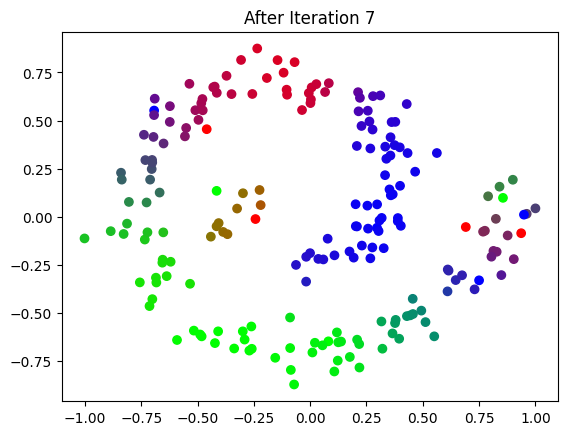

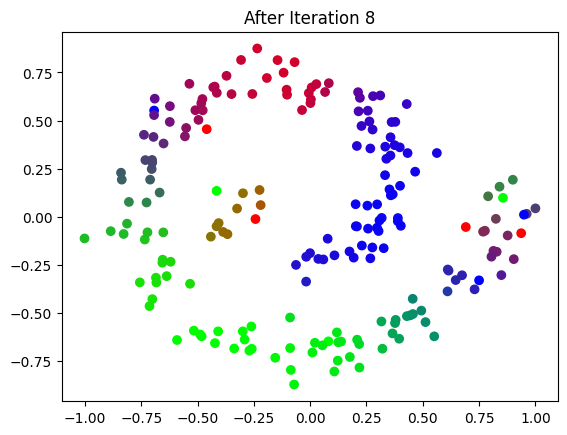

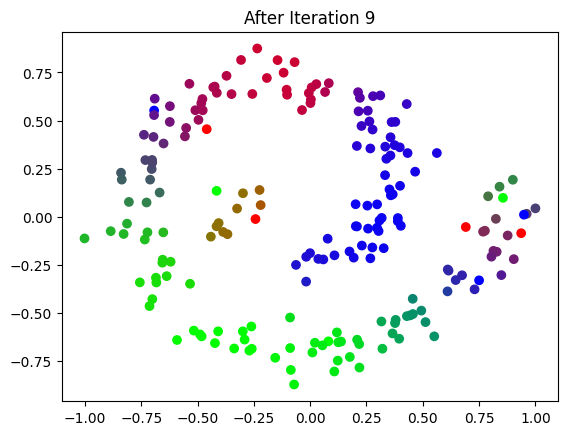

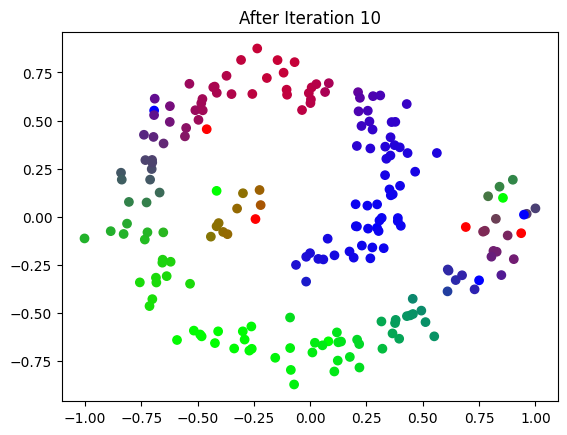

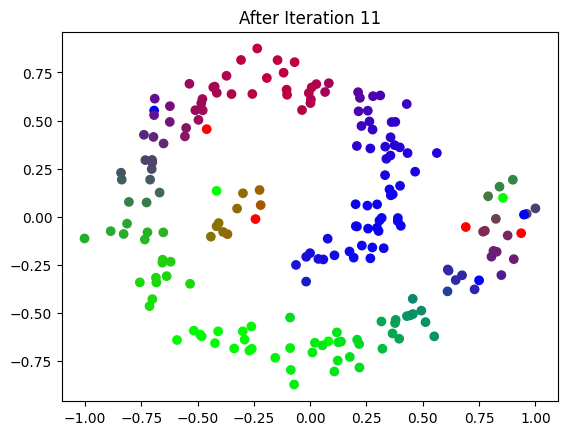

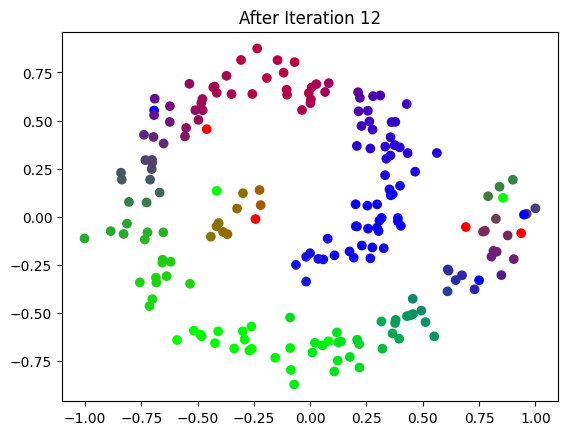

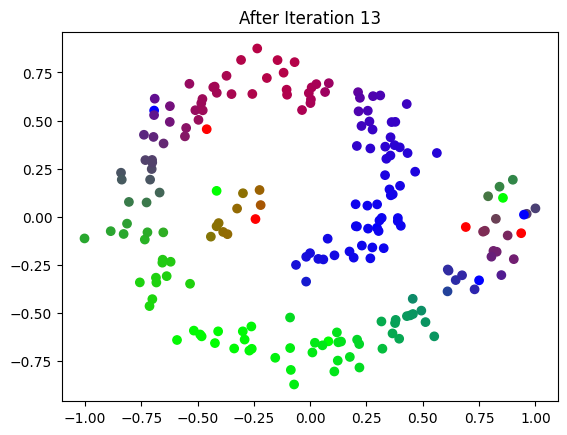

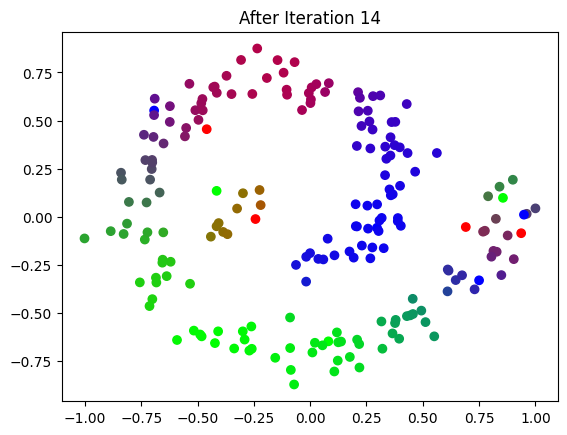

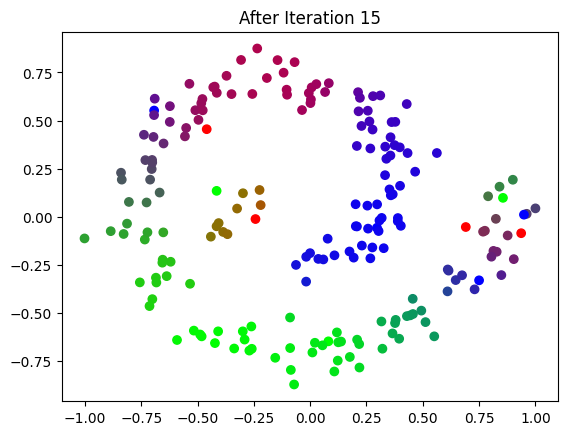

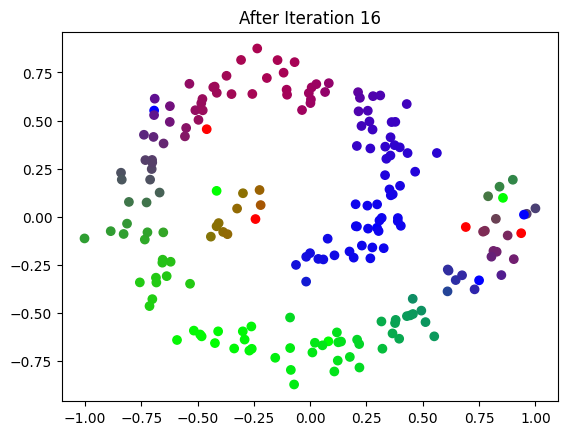

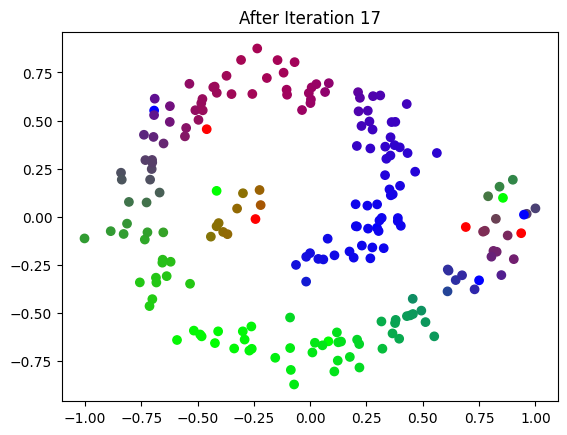

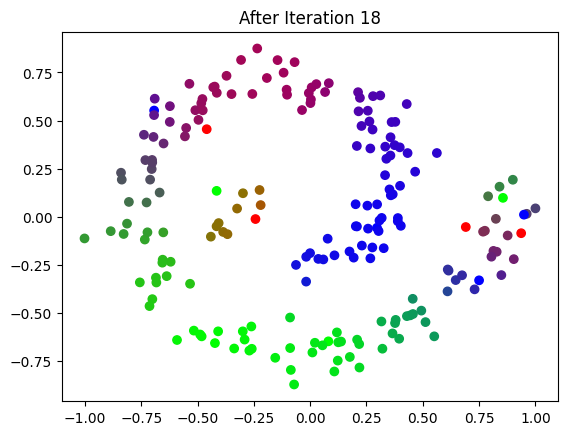

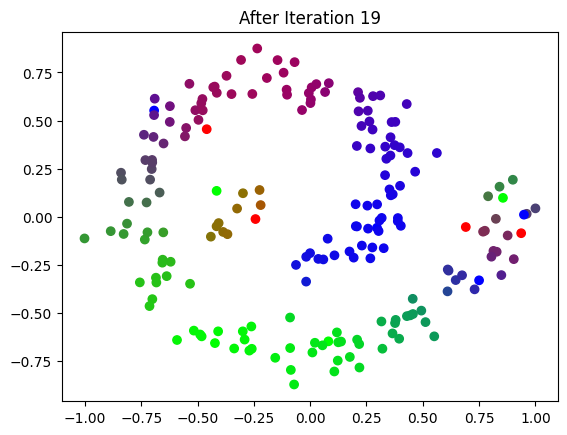

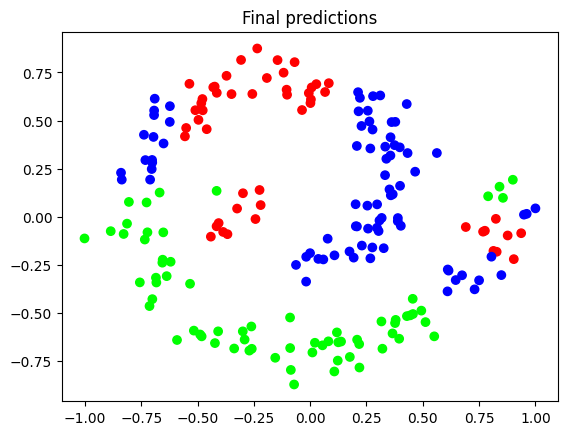

In [30]:
num_iters = 20
lp = LabelPropagation(num_iters)
predictions = lp(A, x, coords)
plot_predictions(predictions, coords)

We will add a stopping criterion to our algorithm, and stop training when the updates of all points $i$ satisfy $||x_i^{t+1} - x_i^t||_2 \leq \epsilon$.

**Question 11 (code) [3pt]: Implement the uniform variation criterion.** *You can use the function `scipy.linalg.norm`*.

Tip: don't forget that unexpected behaviours can happen when arrays are modified in place. To avoid this, you can use `np.copy()`.

In [31]:
from scipy.linalg import norm

class UniformVariationCriterion():
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.last_values = None
        
    def step(self, x):
        """ Return True if the class probabilities for each point have changed by less than epsilon,
            False otherwise.
        """
        # Your solution here ###########################################################
        criterion = False

        if self.last_values is not None:
            values = norm(x - self.last_values, axis=1)
            criterion = np.all(values < self.threshold)

        self.last_values = x.copy()

        return criterion

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

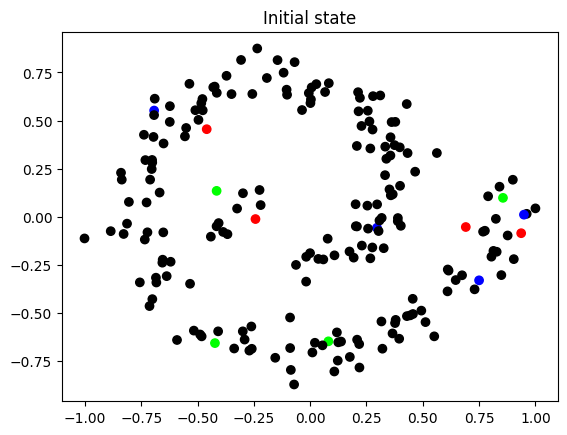

Stopping criterion triggered after 30 iterations.


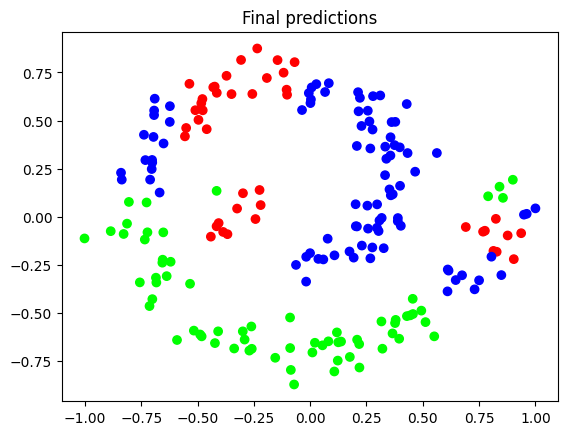

In [32]:
stopping_criterion = UniformVariationCriterion()
num_iters = 200

x = sample_signal(n)
lp = LabelPropagation(num_iters, stopping_criterion)
predictions = lp(A, x, coords, plot_each_iteration=False)
plot_predictions(predictions, coords)

An alternative way to perform semi-supervised learning is to apply a low-pass filter on the signal. Use the functions defined in the previous exercises to apply a Tikhonov filter with $\alpha=1$ to the signal `x`.

**Question 12 (code) [3pt]: Connection with low-pass filtering. Use the functions defined in the previous exercises to compute a Tikhonov filter. Apply this filter to the signal `x` to compute predictions for unseen nodes.**


In [33]:
# Your solution here ###########################################################
L = compute_laplacian(A, normalize=None)
L = (L + L.T)/2
lam, U = spectral_decomposition(L)

alpha = 1
ideal_tk = 1 / (1 + alpha*lam)
filtered = filter_signal(x, ideal_tk, U)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

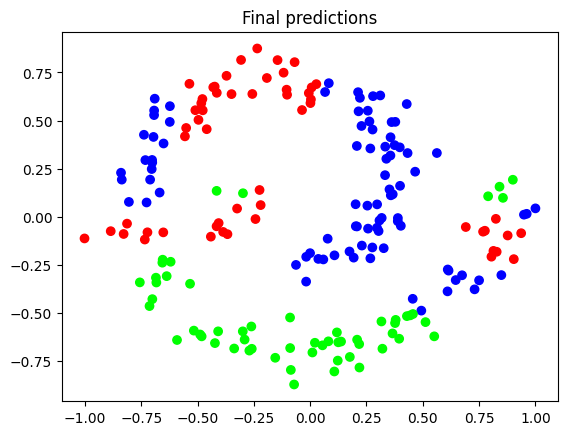

In [34]:
plot_predictions(filtered, coords)

We observe that label propagation gives very similar results as the low-pass filter.